In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
import numpy as np
from admm.agents import FedConsensus
from admm.servers import EventADMM
from admm.models import FCNet
from admm.utils import average_params
from admm.data import partition_data, split_dataset
import seaborn as sns
sns.set_theme()

%matplotlib inline

In [2]:
cifar_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

cifar_trainset = datasets.CIFAR10(
    root='./data/cifar10', train=True,
    download=True, transform=cifar_transform
)
cifar_testset = datasets.CIFAR10(
    root='./data/cifar10', train=False,
    download=True, transform=cifar_transform
)

mnist_transform = transforms.Compose([
    transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,)), transforms.Lambda(lambda x: torch.flatten(x))
])

mnist_trainset = datasets.MNIST(
    root='./data/mnist_data', train=True,
    download=True, transform=mnist_transform, 
)
mnist_testset = datasets.MNIST(
    root='./data/mnist_data', train=False,
    download=True, transform=mnist_transform
)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
train_dataset, val_dataset, _ = split_dataset(dataset=mnist_trainset, train_ratio=0.8, val_ratio=0.2)

trainsets = partition_data(
    num_clients=100,
    iid=False,
    balance=True,
    power_law=False,
    seed=42,
    trainset=train_dataset.dataset,
    labels_per_partition=1
)

for i, dataset in enumerate(trainsets):
    labels = np.zeros(10)
    dummy_loader = DataLoader(dataset, batch_size=1)
    for data, target in dummy_loader:
        labels[target.item()] += 1
    print(f'Dataset {i} distribution: {labels} - num_samples = {labels.sum()}')

labels = np.zeros(10)
dummy_loader = DataLoader(val_dataset, batch_size=1)
for data, target in dummy_loader:
    labels[target.item()] += 1
print(f'Validation dataset {i} distribution: {labels} - num_samples = {labels.sum()}')

labels = np.zeros(10)
dummy_loader = DataLoader(mnist_testset, batch_size=1)
for data, target in dummy_loader:
    labels[target.item()] += 1
print(f'Validation dataset {i} distribution: {labels} - num_samples = {labels.sum()}')

Dataset 0 distribution: [  0.   0. 271.   0.   0.   0.   0. 271.   0.   0.] - num_samples = 542.0
Dataset 1 distribution: [  0.   0.   0. 271.   0.   0.   0.   0.   0. 271.] - num_samples = 542.0
Dataset 2 distribution: [  0.   0. 542.   0.   0.   0.   0.   0.   0.   0.] - num_samples = 542.0
Dataset 3 distribution: [271.   0.   0. 271.   0.   0.   0.   0.   0.   0.] - num_samples = 542.0
Dataset 4 distribution: [  0.   0. 271.   0.   0.   0.   0.   0. 271.   0.] - num_samples = 542.0
Dataset 5 distribution: [  0.   0.   0.   0. 271. 271.   0.   0.   0.   0.] - num_samples = 542.0
Dataset 6 distribution: [  0.   0. 271.   0.   0.   0.   0.   0. 271.   0.] - num_samples = 542.0
Dataset 7 distribution: [  0.   0.   0. 271.   0.   0.   0. 271.   0.   0.] - num_samples = 542.0
Dataset 8 distribution: [  0.   0.   0.   0.   0.   0.   0.   0. 271. 271.] - num_samples = 542.0
Dataset 9 distribution: [  0.   0.   0.   0. 271. 271.   0.   0.   0.   0.] - num_samples = 542.0
Dataset 10 distribut

In [4]:
batch_size = 28
train_loaders = [DataLoader(dataset, batch_size=batch_size, shuffle=True) for dataset in trainsets]
test_loader = DataLoader(mnist_testset, batch_size=100, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=100, shuffle=True)

In [5]:
deltas = np.arange(start=1, stop=6, step=0.25).tolist()
deltas = [*deltas, 0]
print(f'testing for {len(deltas)} deltas')

lr = 0.001
rho = 0.01
t_max = 100
loaders = train_loaders
device = 'cpu'

acc_per_delta = np.zeros((len(deltas), t_max))
rate_per_delta = np.zeros((len(deltas), t_max))
loads = []
test_accs = []

print(f'N = {len(loaders)}')
_N = 0
for loader in loaders:
    _N += len(loader.dataset)

for i, delta in enumerate(deltas):
    
    agents = []
    for loader in loaders:
        torch.manual_seed(78)
        model = FCNet(in_channels=784, hidden1=200, hidden2=None, out_channels=10)
        agents.append(
            FedConsensus(
                N=len(loaders),
                delta=delta,
                rho=rho,
                model=model,
                loss=nn.CrossEntropyLoss(),
                train_loader=loader,
                epochs=1,
                data_ratio=len(loader.dataset)/_N,
                device=device,
                lr=lr
            ) 
        )

    # Broadcast average to all agents and check if equal
    for agent in agents:
        agent.primal_avg = average_params([agent.model.parameters() for agent in agents])
    
    # Check that all agents start with same params
    # for agent1 in agents:
    #     for agent2 in agents:
    #         for param1, param2 in zip(agent1.model.parameters(), agent2.model.parameters()):
    #             if not torch.equal(param1, param2): raise ValueError("Initial params aren't equal")
    
    # # Check to make sure they all start with the same average
    # for agent1 in agents:
    #     for agent2 in agents:
    #         for param1, param2 in zip(agent1.primal_avg, agent2.primal_avg):
    #             param1, param2 = torch.Tensor(param1), torch.Tensor(param2)
    #             if not torch.equal(param1, param2): raise ValueError("Averaged params aren't equal")
    #             if torch.equal(param1, torch.zeros(param1.shape)) or torch.equal(param2, torch.zeros(param1.shape)):
    #                 raise ValueError('Averaged Params are zero')
    # print('Parameter check complete!')

    # Run consensus algorithm
    server = EventADMM(clients=agents, t_max=t_max)
    server.spin(loader=val_loader)
    final = agents[0].last_communicated
    
    # For plotting purposes
    acc_per_delta[i,:] = server.val_accs
    rate_per_delta[i,:] = server.rates
    load = sum(rate_per_delta[i,:])/t_max
    acc = server.validate_global(loader=test_loader)
    print(f'Load for delta {delta} = {load}, Test accuracy = {acc}')

    loads.append(load)
    test_accs.append(acc)

testing for 21 deltas
N = 100


Comm: 0.980, Global Acc = 0.9522, min Delta: 0.99658526, max Delta: 2.01271140, avg: 1.28144173: 100%|██████████| 100/100 [12:14<00:00,  7.34s/it]


Load for delta 1.0 = 0.9781999999999995, Test accuracy = 0.949400007724762


Comm: 0.810, Global Acc = 0.9525, min Delta: 0.96217153, max Delta: 2.30043169, avg: 1.46819662: 100%|██████████| 100/100 [12:09<00:00,  7.29s/it]


Load for delta 1.25 = 0.8149, Test accuracy = 0.9492999911308289


Comm: 0.580, Global Acc = 0.9527, min Delta: 0.89181225, max Delta: 2.80575039, avg: 1.55300380: 100%|██████████| 100/100 [11:56<00:00,  7.16s/it]


Load for delta 1.5 = 0.6384000000000001, Test accuracy = 0.9485999941825867


Comm: 0.650, Global Acc = 0.9488, min Delta: 0.99741732, max Delta: 3.30330981, avg: 1.96106533: 100%|██████████| 100/100 [11:59<00:00,  7.19s/it]


Load for delta 1.75 = 0.5277999999999998, Test accuracy = 0.9473999738693237


Comm: 0.620, Global Acc = 0.9513, min Delta: 0.99784001, max Delta: 3.47124759, avg: 2.27527022: 100%|██████████| 100/100 [12:00<00:00,  7.20s/it]


Load for delta 2.0 = 0.48669999999999974, Test accuracy = 0.9472000002861023


Comm: 0.360, Global Acc = 0.9484, min Delta: 1.19551447, max Delta: 3.92748735, avg: 1.73210469: 100%|██████████| 100/100 [11:53<00:00,  7.14s/it]


Load for delta 2.25 = 0.45319999999999994, Test accuracy = 0.9437999725341797


Comm: 0.380, Global Acc = 0.9477, min Delta: 0.91786696, max Delta: 3.60308516, avg: 2.01182953: 100%|██████████| 100/100 [11:58<00:00,  7.19s/it]


Load for delta 2.5 = 0.4162000000000002, Test accuracy = 0.9448000192642212


Comm: 0.410, Global Acc = 0.9490, min Delta: 0.99117733, max Delta: 4.08784839, avg: 2.52419718: 100%|██████████| 100/100 [11:54<00:00,  7.15s/it]


Load for delta 2.75 = 0.38400000000000006, Test accuracy = 0.9451000094413757


Comm: 0.280, Global Acc = 0.9452, min Delta: 1.05418769, max Delta: 4.15825053, avg: 2.08554329: 100%|██████████| 100/100 [11:57<00:00,  7.17s/it]


Load for delta 3.0 = 0.35479999999999995, Test accuracy = 0.9424999952316284


Comm: 0.290, Global Acc = 0.9388, min Delta: 1.10132491, max Delta: 4.62133699, avg: 2.46046739: 100%|██████████| 100/100 [11:45<00:00,  7.06s/it]


Load for delta 3.25 = 0.32830000000000004, Test accuracy = 0.9355000257492065


Comm: 0.260, Global Acc = 0.9428, min Delta: 1.10298608, max Delta: 4.84979609, avg: 2.73547457: 100%|██████████| 100/100 [11:43<00:00,  7.03s/it]


Load for delta 3.5 = 0.3009, Test accuracy = 0.9401000142097473


Comm: 0.290, Global Acc = 0.9413, min Delta: 1.06869305, max Delta: 5.10057942, avg: 2.97561980: 100%|██████████| 100/100 [11:47<00:00,  7.07s/it]


Load for delta 3.75 = 0.2796999999999999, Test accuracy = 0.9423999786376953


Comm: 0.410, Global Acc = 0.9273, min Delta: 1.26985433, max Delta: 5.66364748, avg: 3.61884442: 100%|██████████| 100/100 [11:48<00:00,  7.08s/it]


Load for delta 4.0 = 0.26319999999999993, Test accuracy = 0.9247000217437744


Comm: 0.260, Global Acc = 0.9252, min Delta: 1.22301134, max Delta: 5.83173940, avg: 3.47279309: 100%|██████████| 100/100 [11:48<00:00,  7.09s/it]


Load for delta 4.25 = 0.2474, Test accuracy = 0.9243000149726868


Comm: 0.310, Global Acc = 0.9002, min Delta: 1.15147005, max Delta: 5.86377493, avg: 3.69455276: 100%|██████████| 100/100 [11:47<00:00,  7.07s/it]


Load for delta 4.5 = 0.23540000000000014, Test accuracy = 0.8986999988555908


Comm: 0.150, Global Acc = 0.9305, min Delta: 1.10149190, max Delta: 6.36661913, avg: 3.65644283: 100%|██████████| 100/100 [11:43<00:00,  7.04s/it]


Load for delta 4.75 = 0.22690000000000002, Test accuracy = 0.9264000058174133


Comm: 0.230, Global Acc = 0.9434, min Delta: 1.09485515, max Delta: 6.69090480, avg: 3.98010148: 100%|██████████| 100/100 [11:42<00:00,  7.03s/it]


Load for delta 5.0 = 0.22099999999999997, Test accuracy = 0.9412000179290771


Comm: 0.200, Global Acc = 0.9187, min Delta: 1.29382365, max Delta: 7.02104805, avg: 3.98817859: 100%|██████████| 100/100 [11:49<00:00,  7.09s/it]


Load for delta 5.25 = 0.21030000000000001, Test accuracy = 0.9168999791145325


Comm: 0.180, Global Acc = 0.9468, min Delta: 1.34924103, max Delta: 6.98814744, avg: 4.19051781: 100%|██████████| 100/100 [11:53<00:00,  7.14s/it]


Load for delta 5.5 = 0.19970000000000002, Test accuracy = 0.9430999755859375


Comm: 0.200, Global Acc = 0.9031, min Delta: 1.40266028, max Delta: 7.25666578, avg: 4.52263781: 100%|██████████| 100/100 [11:51<00:00,  7.11s/it]


Load for delta 5.75 = 0.19230000000000003, Test accuracy = 0.9031000137329102


Comm: 1.000, Global Acc = 0.9532, min Delta: 0.92853402, max Delta: 1.97214062, avg: 1.27990324: 100%|██████████| 100/100 [11:58<00:00,  7.18s/it]


Load for delta 0 = 1.0, Test accuracy = 0.9491999745368958


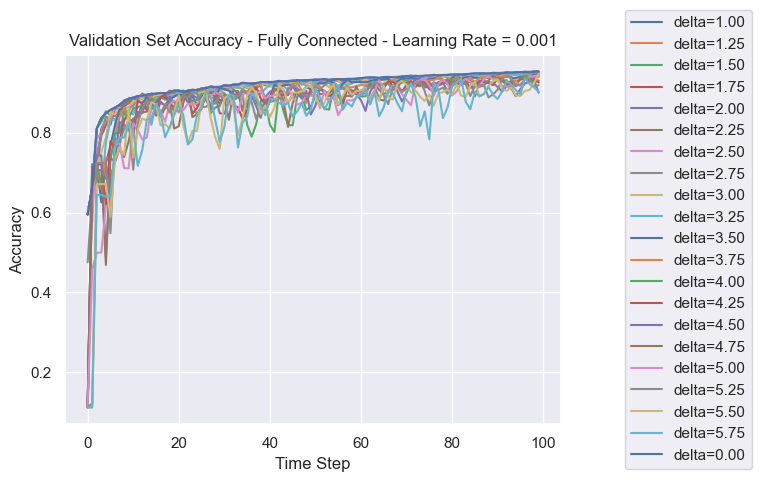

In [10]:
T = range(t_max)
# Plot accuracies
for acc, delta in zip(acc_per_delta, deltas):
    plt.plot(T, acc, label=f'delta={delta:.2f}')
plt.legend(loc='center right', bbox_to_anchor=(1.4, 0.5))
plt.xlabel('Time Step')
plt.ylabel('Accuracy')
plt.title('Validation Set Accuracy - Fully Connected - Learning Rate = 0.001')
plt.savefig('./images/mnist/fc_val.png')
plt.show()


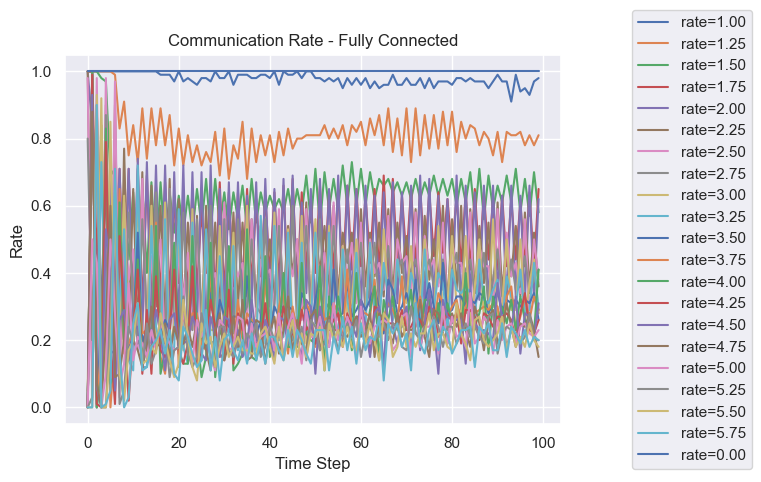

In [11]:
for rate, delta in zip(rate_per_delta, deltas):
    plt.plot(T, rate, label=f'rate={delta:.2f}')
plt.legend(loc='center right', bbox_to_anchor=(1.4, 0.5))
plt.xlabel('Time Step')
plt.ylabel('Rate')
plt.title('Communication Rate - Fully Connected')
plt.savefig('./images/mnist/fc_comm_rate.png')
plt.show()


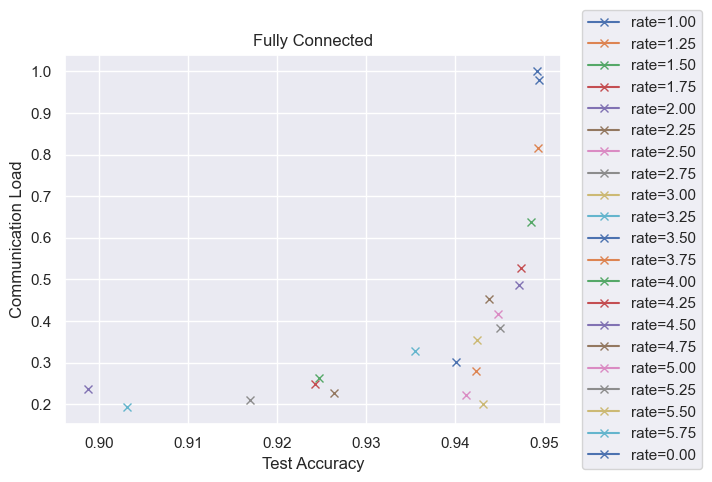

In [12]:
for load, acc, delta in zip(loads, test_accs, deltas):
    plt.plot(acc, load, label=f'rate={delta:.2f}', marker='x')
plt.legend(loc='center right', bbox_to_anchor=(1.3, 0.5))
plt.xlabel('Test Accuracy')
plt.ylabel('Communication Load')
plt.title('Fully Connected')
plt.savefig('./images/mnist/fc_test_load.png')
plt.show()


In [ ]:
np.save(file='figure_data/mnist/rates_per_delta', arr=rate_per_delta)
np.save(file='figure_data/mnist/accs_per_delta', arr=acc_per_delta)
np.save(file='figure_data/mnist/loads_per_delta', arr=loads)
np.save(file='figure_data/mnist/deltas', arr=deltas)